As base model, I will take easyOCR (though yeah, perfectly, it should be our custom model:).

In [9]:
import json
from cleanlab.object_detection.filter import find_label_issues
from cleanlab.object_detection.rank import (
    _separate_label,
    _separate_prediction,
    get_label_quality_scores,
    issues_from_scores,
)
from cleanlab.object_detection.summary import visualize 
import easyocr
from PIL import Image, ImageDraw
import numpy as np

reader = easyocr.Reader(['en'])

/Users/glibesyck/miniconda3/envs/cleanlab/lib/python3.11/site-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDi

Loading data from annotations.

In [74]:
json_path = "annotations.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)


parsed_data = []
for item in data:
    image_name = item["id"]
    annotations = item["annotations"][0]["result"]
    
    bboxes = []
    for annotation in annotations:
        orig_width = annotation['original_width']
        orig_height = annotation['original_height']
        value = annotation["value"]
        
        x = int(value["x"] * orig_width / 100)
        y = int(value["y"] * orig_height / 100)
        width = int(value["width"] * orig_width / 100)
        height = int(value["height"] * orig_height / 100)

        bboxes.append([x, y, x + width, y + height])
    
    parsed_data.append({"image": f'{image_name}.png', "bboxes": bboxes})

Predictions from EasyOCR.

In [75]:
full_data = []

for entry in parsed_data:
    image_name = entry['image']
    image = Image.open(image_name).convert("RGB")
    image_np = np.array(image)
    results = reader.readtext(image_np)
    
    bboxes = []
    for (bbox, text, confidence) in results:
        if confidence > 0.5:
            x_min, y_min = bbox[0]
            x_max, y_max = bbox[2]
            bboxes.append(
                [x_min, y_min, x_max, y_max],
            )
    
    full_data.append({"image": image_name, "label": entry["bboxes"], "prediction": bboxes})

Visualization of one example.

In [44]:
def visualize_bboxes(image_path, labeled_bboxes, model_bboxes):
    """
    Draws labeled bounding boxes in red and model-predicted bounding boxes in blue.
    
    :param image_path: Path to the image file.
    :param labeled_bboxes: List of bounding boxes from labeling (red). Format: [[x, y, w, h], ...]
    :param model_bboxes: List of bounding boxes from the model (blue). Format: [[x, y, w, h], ...]
    """
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    # Draw labeled bounding boxes (red)
    for bbox in labeled_bboxes:
        x1, y1, x2, y2 = bbox
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    # Draw model-predicted bounding boxes (blue)
    for bbox in model_bboxes:
        x1, y1, x2, y2 = bbox
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=3)

    image.show()  # Show image with bounding boxes
    return image  # Return PIL image object for further use

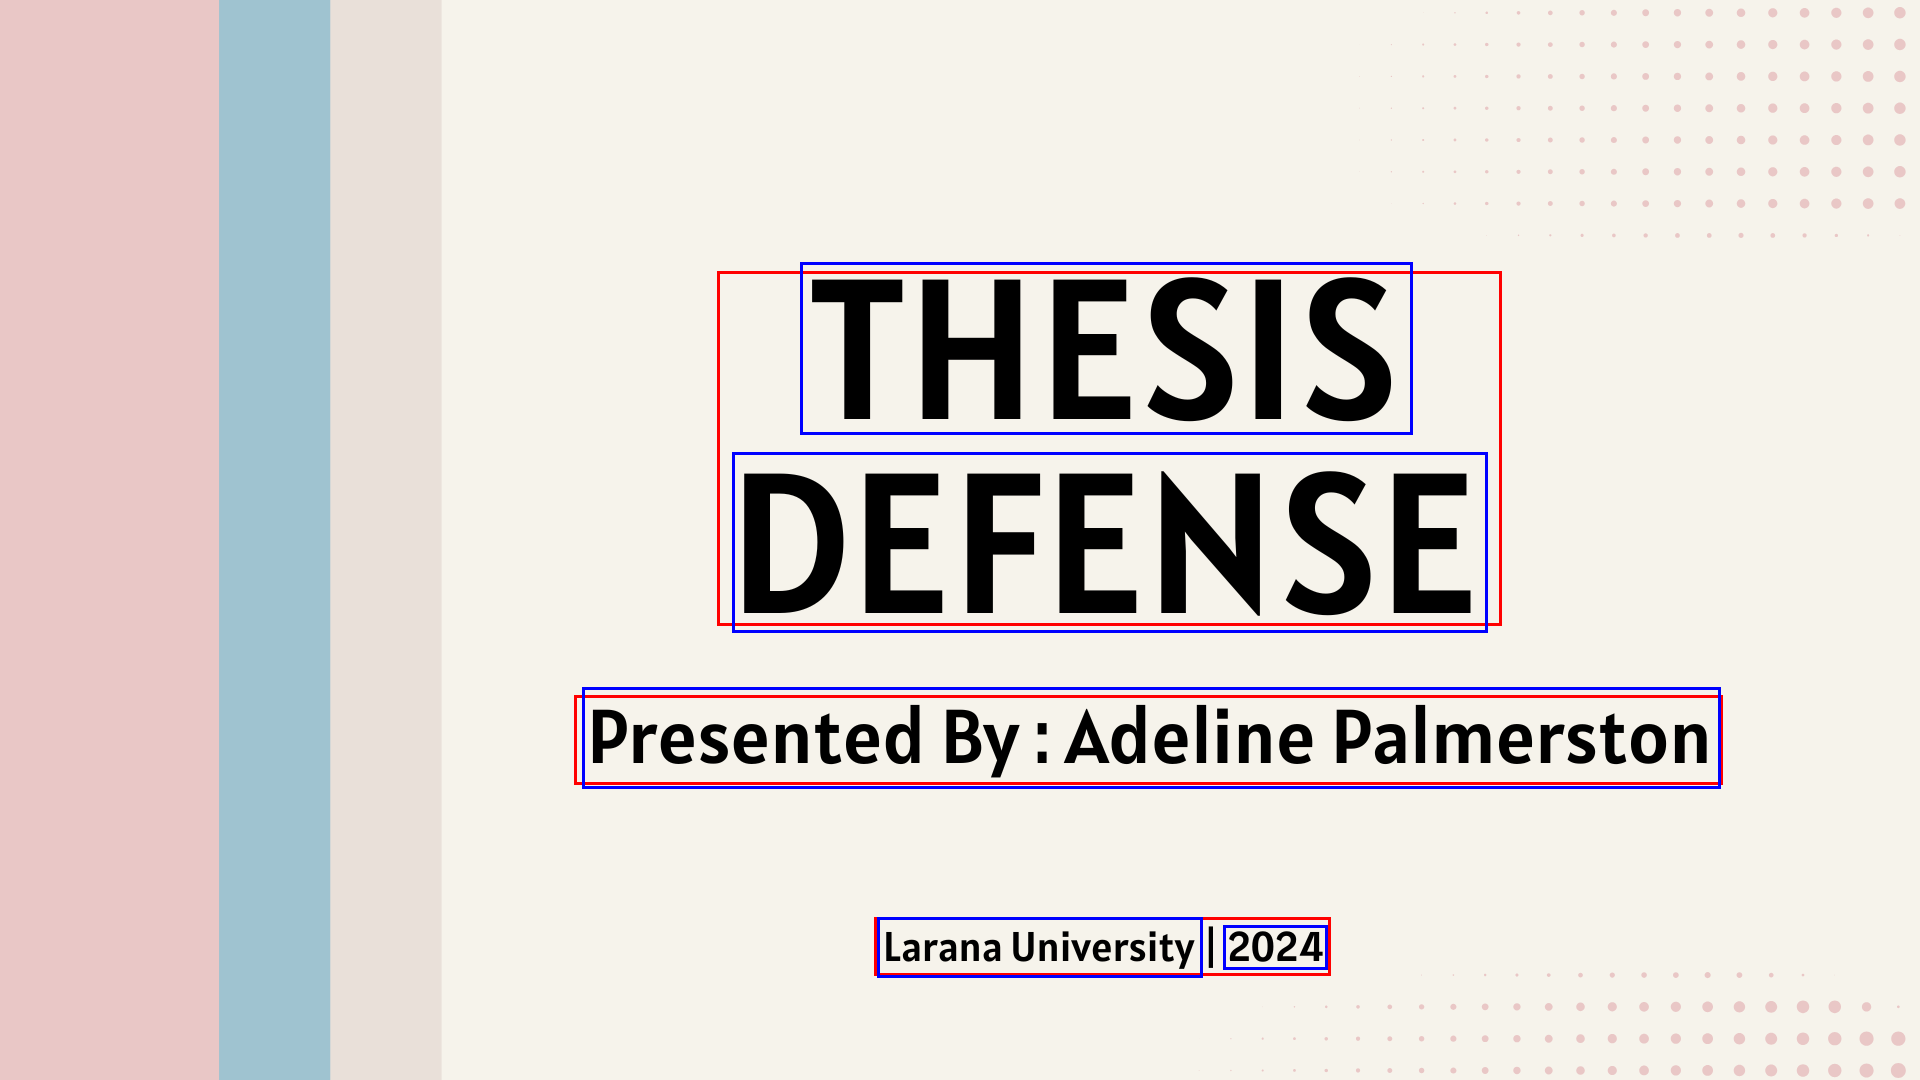

In [45]:
visualize_bboxes(full_data[0]["image"], full_data[0]["label"], full_data[0]["prediction"])

Visualization using `cleanlab` function. For that, we need to translate labels and predictions to another format.

In [88]:
def format_label_bboxes(bboxes, file_name, class_id=0):
    bboxes_array = np.array(bboxes, dtype=np.float32)
    
    return {
            "bboxes": bboxes_array,
            "labels": np.array([class_id] * len(bboxes), dtype=np.int32),
            "bboxes_ignore": np.empty((0, 4), dtype=np.float32),
            "masks": [],
            "seg_map": file_name
    }


def format_prediction_bboxes(bboxes):
    results = []
    for entry in bboxes:
        results.append(entry + [1])
    return np.array(np.array(results, dtype=np.float32)).reshape(1, len(results), 5)

In [89]:
upd_full_data = []
for entry in full_data:
    upd_full_data.append({"image": entry["image"], "label": format_label_bboxes(entry["label"], entry["image"]), "prediction": format_prediction_bboxes(entry["prediction"])})

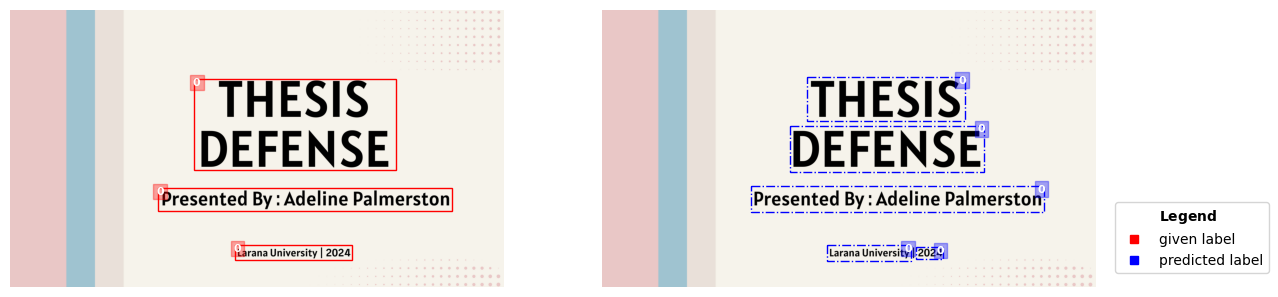

In [91]:
visualize(upd_full_data[0]["image"], label=upd_full_data[0]["label"], prediction=upd_full_data[0]["prediction"], overlay=False)

Which images have label issues.

In [92]:
labels = []
predictions = []
for entry in upd_full_data:
    labels.append(entry["label"])
    predictions.append(entry["prediction"])

In [93]:
label_issue_idx = find_label_issues(labels, predictions, return_indices_ranked_by_score=True)
print(label_issue_idx)

Pruning 0 predictions out of 10 using threshold==0.0. These predictions are no longer considered as potential candidates for identifying label issues as their similarity with the given labels is no longer considered.
[2 8 3 4 9 7 6 5]


Well, 8/10 :) Now, we are going to visualize label issues.

3.png


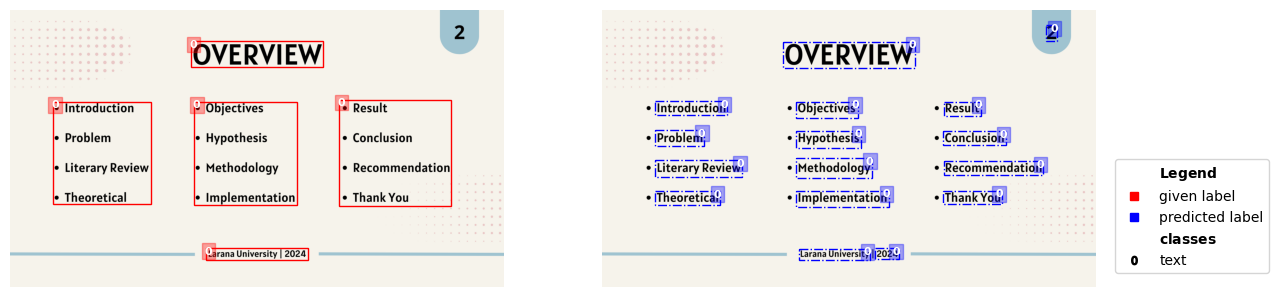

In [ ]:
issue_to_visualize = label_issue_idx[0]
class_names = {"0": "text"}

label = labels[issue_to_visualize]
prediction = predictions[issue_to_visualize]
image_path = str(issue_to_visualize + 1) + ".png"

print(image_path)
visualize(image_path, label=label, prediction=prediction, class_names=class_names, overlay=False)

9.png


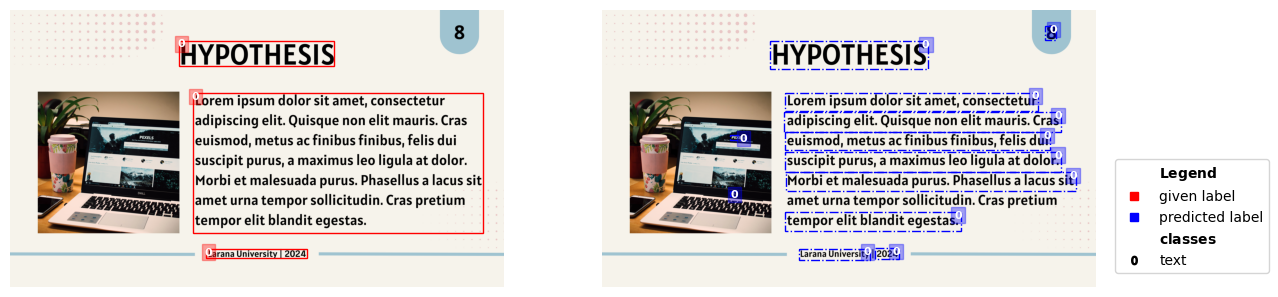

In [99]:
issue_to_visualize = label_issue_idx[1]
class_names = {"0": "text"}

label = labels[issue_to_visualize]
prediction = predictions[issue_to_visualize]
image_path = str(issue_to_visualize + 1) + ".png"

print(image_path)
visualize(image_path, label=label, prediction=prediction, class_names=class_names, overlay=False)

4.png


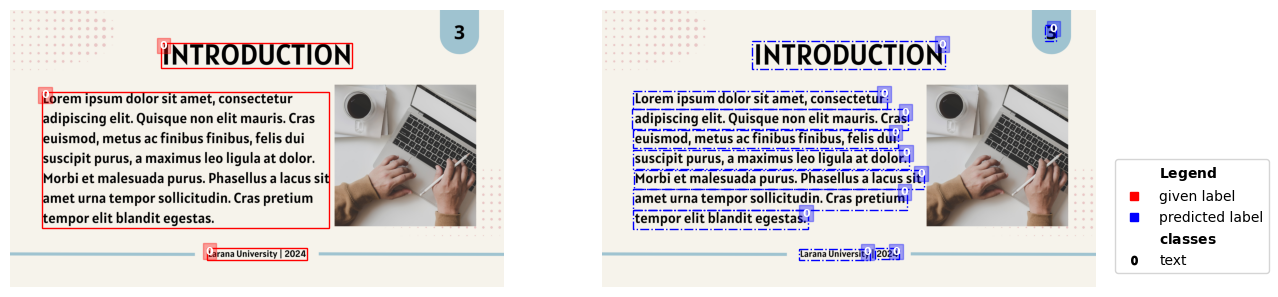

In [100]:
issue_to_visualize = label_issue_idx[2]
class_names = {"0": "text"}

label = labels[issue_to_visualize]
prediction = predictions[issue_to_visualize]
image_path = str(issue_to_visualize + 1) + ".png"

print(image_path)
visualize(image_path, label=label, prediction=prediction, class_names=class_names, overlay=False)

We can the issue with EasyOCR - it detects every line separately! Something we account for in labeled dataset.